In [1]:
import torch
import numpy as np
import argparse
import imutils
import time
import cv2

from PIL import Image, ImageOps
from torchvision import transforms

from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
# classes = ['(', ')', ',', '-', 
#                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
#                    'A', '[', 'α', 'and', 'β', '∃', 'F', '∀', 
#                    'γ', 'λ', 'μ', 'ω', 'or', 'φ', '→', 
#                    'σ', 'sqrt', 'θ', 'v', 'x', 'y', 'z']

classes = ['(', ')', '+', ',', '-', 
                     '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                     'A', 'F','α','and','β', 'delta', '∃', '∀',
                     'γ', 'λ', 'μ', 'not','ω','or','φ','pi','psi','→',
                     'σ','tau','θ','v','x', 'y', 'z']

NUM_CLASSES = len(classes)


def map_pred(ind):
    if ind < NUM_CLASSES:
        return classes[ind]
    return 'ERROR MAPPIMG'

MODEL_PATH = 'models\mathnet\mathnet22.ml'
NUM_CLASSES 

40

In [3]:
class ResidiumBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_percentage, is_reducer=True):
        super(ResidiumBlock, self).__init__()
        self.dropout_percentage = dropout_percentage
        self.is_reducer = is_reducer
        if self.is_reducer:
            self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                         kernel_size=3, padding=1, stride=2)
        else:
            self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                         kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                     kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.act1  = torch.nn.ReLU()
        
        self.conv3 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                     kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.conv4 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                     kernel_size=3, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.act2  = torch.nn.ReLU()
        #self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.dropout = nn.Dropout(p=self.dropout_percentage)

    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if not self.is_reducer:
            x += identity
        x = self.act1(x)
        
        identity = x
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        
        x = self.dropout(x)
        x += identity
        x = self.act2(x)
        
        return x

In [4]:
class MathNet(torch.nn.Module):
    def __init__(self, out_size=NUM_CLASSES):
        super(MathNet, self).__init__()
        self.dropout_percentage = 0.25
        
        # 224x224x1 -> 112x112x64
        self.conv1 =  nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.block1 = ResidiumBlock(64, 64, self.dropout_percentage, False)
        self.block2 = ResidiumBlock(64, 128, self.dropout_percentage)
        self.block3 = ResidiumBlock(128, 256, self.dropout_percentage)
        self.block4 = ResidiumBlock(256, 512, self.dropout_percentage)

        self.pool3 = torch.nn.AvgPool2d(kernel_size=7, stride=7, padding=0)
        self.dropout3 = nn.Dropout(p=self.dropout_percentage)
        
        self.fc1 = torch.nn.Linear(512, NUM_CLASSES)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)  
        return x

In [5]:
#CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
(H, W) = (400, 400)
class SlidingWindowObjectDetection():
    def __init__(self, pretrained_classifier_path, kwargs):
        self.model = MathNet()
        self.model.load_state_dict(torch.load(pretrained_classifier_path))
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(device)
        self.kwargs = kwargs
    
    def test(self, image, step, ws):
        potential = []
        for y in range(0, image.shape[0] - ws[1], step):
            for x in range(0, image.shape[1] - ws[0], step):
                crop_img = image[y:y+28, x:x+28]
                #print(type(image), type(crop_img))
                crop_tensor = transforms.ToTensor()
                
               
                
                thresh = 120
                ret,thresh_img = cv2.threshold(crop_img, thresh, 255, cv2.THRESH_BINARY)

                #find contours
                contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                img_contours = np.uint8(np.zeros((crop_img.shape[0],crop_img.shape[1])))
                cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
                
                if (len(contours) > 1):
                    #print(x,y, len(contours))
                    #img = Image.fromarray(crop_img.astype('uint8'))
                    #img = Image.fromarray(img_contours.astype('uint8'))
                    #display(img)
                    potential.append(crop_img)
        return potential
    
    def predict(self, lst):
        res = []
        for image in lst:
            img = Image.fromarray(image.astype('uint8'))
            convert_tensor = transforms.Compose([
                transforms.Resize((28,28)),
                transforms.Grayscale(1),
                transforms.ToTensor()

            ])

            
            x_image = convert_tensor(img)
            x_image = x_image.unsqueeze(0).float()
            x_image = x_image.to(device)

            preds = self.model(x_image) 
            prob = preds.max()
            if prob >= self.kwargs['MIN_CONF']:
                print(prob.item(), (map_pred(preds.argmax()), preds))
                img = Image.fromarray(image.astype('uint8'))
                display(img)
            
                res.append((map_pred(preds.argmax()), preds))

        
    def visualize_rois(self, rois):
        fig, axes = plt.subplots(1, len(rois), figsize=(20, 6))
        for ax, roi in zip(axes, rois):
            ax.imshow(roi, cmap='gray')

    
    def get_preds(self, rois, locs):
        rois = np.array(rois, dtype="float32")
        preds = self.predict(rois)
        #preds = list(zip(preds.argmax(axis=1).tolist(), preds.max(axis=1).tolist()))
        res = []
        for i in range(0, len(preds)):
            res.append((map_pred(preds[i].argmax()), preds[i].max()))
        #print(res)
        labels = {}

        for (i, p) in enumerate(res):
            (label, prob) = p
            if prob >= self.kwargs['MIN_CONF']:
                box = locs[i]
                L = labels.get(label, [])
                L.append((box, prob))
                labels[label] = L
        return preds, labels
    
    def __call__(self, img):
        potential = self.test(img, self.kwargs['WIN_STEP'], self.kwargs['ROI_SIZE'])
        self.predict(potential)
        
        rois, locs = self.get_rois_and_locs()
        
        preds, labels = self.get_preds(rois, locs)
        nms_labels = self.apply_nms(labels)
        if self.kwargs['VISUALIZE']:
            self.visualize_preds(img, nms_labels)
        return nms_labels



In [7]:
kwargs = dict(
    PYR_SCALE=1.25,
    WIN_STEP=3,
    ROI_SIZE=(21, 21),
    INPUT_SIZE=(28, 28),
    VISUALIZE=True,
    MIN_CONF=0.4
)

In [8]:
IMAGE_NAME = 'TEST/5.jpg'
image = cv2.imread(IMAGE_NAME)

img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

#set a thresh
thresh = 120

#get threshold image
ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)

#find contours
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))



In [9]:
cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
1

1

In [10]:
sw = SlidingWindowObjectDetection(MODEL_PATH, kwargs)
IMAGE_NAME = 'TEST/5.jpg'
image = cv2.imread(IMAGE_NAME)
img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
print('END')


END


In [11]:
def resize_image(image, dst):
    x = float(dst) / image.shape[1]
    y = float(dst) / image.shape[0]
    return cv2.resize(image, (0,0), fx=x,fy=y, interpolation = cv2.INTER_AREA)

In [12]:
def resize_letter(image, dst):
    return None

In [13]:
class Letter:
    def __init__(self, x, y, w, h, img):
        self.x = x
        self.y = y
        self.width = w
        self.height = h
        self.image = img
        
        self.line = 0
        
        self.bottom = self.y + self.height
        self.top = self.y
        self.left = self.x
        self.right = self.x + self.width
        
    def resize():
        pass

In [14]:
def letters_extract(image_file):
    img = cv2.imread(image_file)
    output = img.copy()
    cv2.imshow('MyPhoto', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    thresh = 100
    thresh_img = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,5,8)
    cv2.imshow('thresh_img', thresh_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    img_erode = thresh_img#cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=3)
#     cv2.imshow('MyPhoto', img_erode)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('img_contours', img_contours )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
       
    # Filter contours
    mask = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if cv2.contourArea(contour) > 10 and cv2.contourArea(contour) < 100:
            cv2.drawContours(mask, [contour], 0, (255), -1)
        else:
            pass
#             dummy = np.uint8(np.zeros((img.shape[0],img.shape[1])))
#             cv2.drawContours(dummy, contour, -1, (255,255,255), 1)
#             print(w*h, cv2.contourArea(contour))
#             cv2.imshow(str(idx), dummy )
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()
            
#     # apply the mask to the original image
    result = cv2.bitwise_and(img,img, mask= mask)   
    cv2.imshow('result', result )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('Contours', img_contours )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        #print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        if hierarchy[0][idx][3] != -1:
            continue
#         mask_contour = img_contours[y:y+h, x:x+w]
#         mask_contour[y_pos:y_pos + h, 0:w] = crop_img
#         cv2.drawContours(mask_contour, contour, -1, (255,255,255), 1)
#         cv2.imshow('MyPhoto', mask_contour)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         cv2.imwrite('mask.png', img * max(img - 100, 0) * 255)
#         ii = cv2.imread('mask.png')
#         cv2.imshow('MyPhoto', ii )
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        crop_img = img_erode[y:y+h, x:x+w]
        #crop_img = thresh_img[y:y+h, x:x+w]
        size_max = max(w, h)
        letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            y_pos = size_max//2 - h//2
            letter_square[y_pos:y_pos + h, 0:w] = crop_img
        elif w < h:
            x_pos = size_max//2 - w//2
            letter_square[0:h, x_pos:x_pos + w] = crop_img
        else:
            letter_square = crop_img
        
        x,y,w,h = cv2.boundingRect(contour)
        rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)      
        inverted = cv2.bitwise_not(letter_square)
        
        letter = Letter(x,y,w,h,letter_square)
        letters.append(letter)

    letters.sort(key=lambda ll: (ll.y, ll.x), reverse=False)
    aaa = Image.fromarray(output.astype('uint8'))
    display(aaa)
    return letters

In [15]:
def average_size(lst):
    if len(lst) <= 0:
        return (0, 0)
    avg_w = 0
    avg_h = 0
    for letter in lst:
        avg_w += letter.width
        avg_h += letter.height
    avg_w /= len(lst)
    avg_h /= len(lst)
    
    return (avg_w, avg_h)

In [28]:
def img_to_str(model, image_file, tp=1):
    letters = letters_extract(image_file)   
    
    print('SHAPE: ', np.array(letters,dtype=object).shape)
    s_out = ""
    if len(letters) == 0:
        return "Found nothing"
    (avg_w, avg_h) = average_size(letters)
    print((avg_w, avg_h))
    
    # True sorting by Y axis
    line = 0
    for i in range (1, len(letters)):
        if letters[i].top > letters[i-1].bottom:
            line += 1
        letters[i].line = line
    letters.sort(key=lambda ll: (ll.line, ll.x), reverse=False)  
    
    prev_loc = (letters[0].x, letters[0].y)
    prev_size = (letters[0].width, letters[0].height)
    prev_line = letters[0].line
    #for i in range(1):
    for i in range(len(letters)):
        img = Image.fromarray(letters[i].image.astype('uint8'))
        convert_tensor = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Grayscale(1),
            transforms.ToTensor()

        ])        
        x_image = convert_tensor(img)
        aaa = transforms.ToPILImage()
        display(aaa(x_image))
        x_image = x_image.unsqueeze(0).float()
        x_image = x_image.to(device)
        pred = model(x_image) 
        am = map_pred(pred.argmax().item())
        #print(letters[i].image.shape, map_pred(pred.argmax().item()), am)
        #dn = letters[i+1][0] - letters[i][0] - letters[i][1] if i < len(letters) - 1 else 0
        #print(am)
        x = letters[i].x
        y = letters[i].y
        size = (letters[i].width, letters[i].height)
        if (letters[i].line >  prev_line):
            s_out += "\n"
            prev_line = letters[i].line
        prev_loc, prev_size = (x,y), size
        s_out += am + ' '
        print(letters[i].image.shape, map_pred(pred.argmax().item()), am)
        
    return s_out

In [29]:
model = MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

EVALUATION


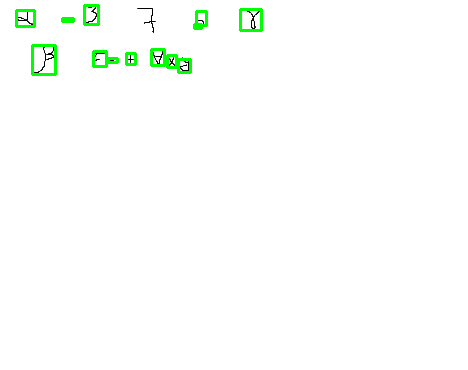

SHAPE:  (13,)
(13.0, 13.615384615384615)


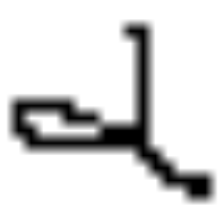

(18, 18) α α


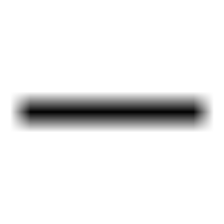

(11, 11) → →


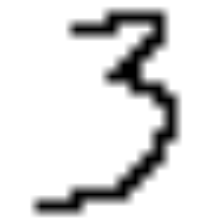

(19, 19) 3 3


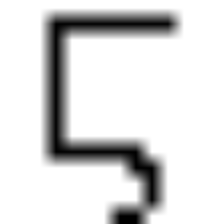

(14, 14) 5 5


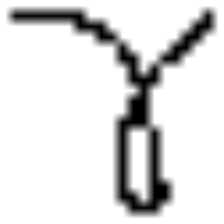

(21, 21) γ γ


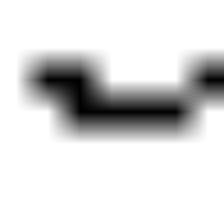

(7, 7) psi psi


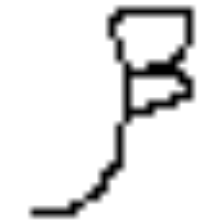

(29, 29) β β


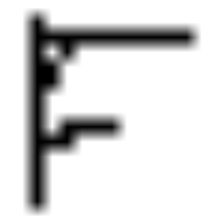

(15, 15) F F


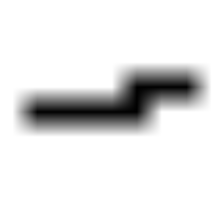

(9, 9) → →


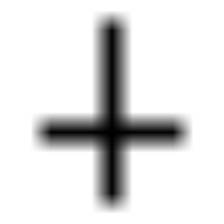

(11, 11) ∀ ∀


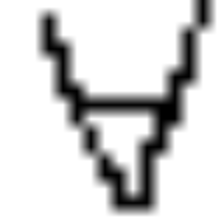

(16, 16) ∀ ∀


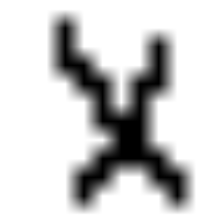

(12, 12) ∀ ∀


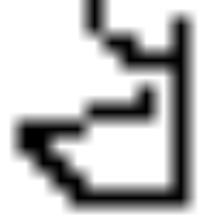

(13, 13) ∀ ∀
RESULT:
α → 3 5 γ 
psi 
β F → ∀ ∀ ∀ ∀ 


In [30]:
s = img_to_str(model, 'TEST/5.jpg', 1)
print('RESULT:')
print(s)

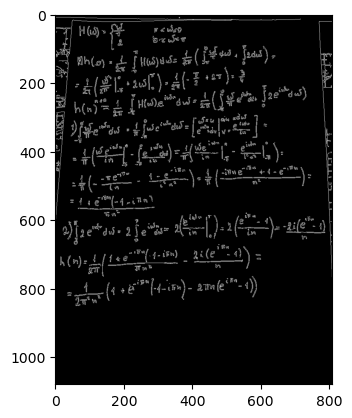

-1

In [19]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('TEST/h.jpg')
edges = cv2.Canny(img,25,255,L2gradient=False)
cv2.imshow('Start image', img)
plt.imshow(edges, cmap='gray')
plt.show()
cv2.waitKey(0)

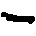

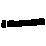

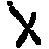

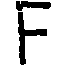

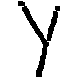

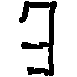

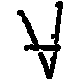

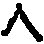

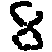

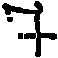

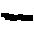

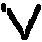

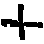

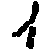

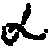

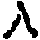

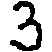

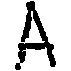

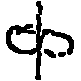

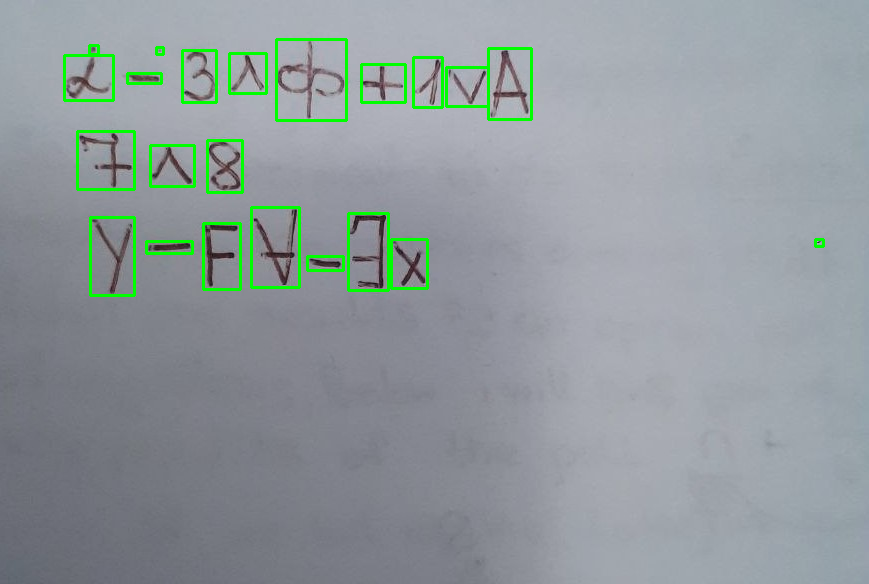

In [20]:

img = cv2.imread('TEST/real4.jpg')
output = img.copy()
cv2.imshow('MyPhoto', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.blur(gray, (3, 3))
cv2.imshow('blurred', blurred)
cv2.waitKey(0)
cv2.destroyAllWindows()

#set a thresh
thresh = 110
ret, thresh_img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# cv2.imshow('thresh_img', thresh_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

thresh_img = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,5,8)
cv2.imshow('thresh_img', thresh_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

#thresh_img = cv2.bitwise_not(thresh_img)

# opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
# cv2.imshow('opening', opening)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# closed = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, np.ones((2, 2), np.uint8))
# cv2.imshow('closed', closed)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


img_erode = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=1)
#img_erode = cv2.dilate(img_erode, np.ones((3, 3), np.uint8), iterations=1)

cv2.imshow('img_erode', img_erode)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Get contours
contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
cv2.imshow('MyPhoto', img_contours )
cv2.waitKey(0)
cv2.destroyAllWindows()

# Filter contours
mask = np.uint8(np.zeros((img.shape[0],img.shape[1])))
for idx, contour in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    if cv2.contourArea(contour) > 10 and cv2.contourArea(contour) < 10000:
        cv2.drawContours(mask, [contour], 0, (255), -1)
    else:
        pass
#             dummy = np.uint8(np.zeros((img.shape[0],img.shape[1])))
#             cv2.drawContours(dummy, contour, -1, (255,255,255), 1)
#             print(w*h, cv2.contourArea(contour))
#             cv2.imshow(str(idx), dummy )
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()

#     # apply the mask to the original image
result = cv2.bitwise_and(img,img, mask=mask)   
cv2.imshow('result', mask )
cv2.waitKey(0)
cv2.destroyAllWindows()

contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
cv2.imshow('img_contours', img_contours )
cv2.waitKey(0)
cv2.destroyAllWindows()

letters = []
for idx, contour in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    #print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
    if hierarchy[0][idx][3] != -1:
        continue
#         mask_contour = img_contours[y:y+h, x:x+w]
#         mask_contour[y_pos:y_pos + h, 0:w] = crop_img
#         cv2.drawContours(mask_contour, contour, -1, (255,255,255), 1)
#         cv2.imshow('MyPhoto', mask_contour)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         cv2.imwrite('mask.png', img * max(img - 100, 0) * 255)
#         ii = cv2.imread('mask.png')
#         cv2.imshow('MyPhoto', ii )
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
    crop_img = img_erode[y:y+h, x:x+w]
    #crop_img = cv2.bitwise_not(crop_img)
    #crop_img = thresh_img[y:y+h, x:x+w]
    size_max = max(w, h)
    letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
    if w > h:
        y_pos = size_max//2 - h//2
        letter_square[y_pos:y_pos + h, 0:w] = crop_img
    elif w < h:
        x_pos = size_max//2 - w//2
        letter_square[0:h, x_pos:x_pos + w] = crop_img
    else:
        letter_square = crop_img

    x,y,w,h = cv2.boundingRect(contour)
    rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)      
    inverted = cv2.bitwise_not(letter_square)
    
    aaa = transforms.ToPILImage()
    display(aaa(letter_square))
    
    letter = Letter(x,y,w,h,letter_square)
    letters.append(letter)

letters.sort(key=lambda ll: (ll.y, ll.x), reverse=False)
aaa = Image.fromarray(output.astype('uint8'))
display(aaa)


In [21]:
# Get contours
    contours, hierarchy = cv2.findContours(sobel2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('MyPhoto', img_contours )
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Filter contours
    mask = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if cv2.contourArea(contour) > 100 and cv2.contourArea(contour) < 10000:
            cv2.drawContours(mask, [contour], 0, (255), -1)
        else:
            pass
    #             dummy = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    #             cv2.drawContours(dummy, contour, -1, (255,255,255), 1)
    #             print(w*h, cv2.contourArea(contour))
    #             cv2.imshow(str(idx), dummy )
    #             cv2.waitKey(0)
    #             cv2.destroyAllWindows()

    #     # apply the mask to the original image
    result = cv2.bitwise_and(img,img, mask=mask)   
#     cv2.imshow('result', mask )
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
#     cv2.imshow('img_contours', img_contours )
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        #print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        if hierarchy[0][idx][3] != -1:
            continue
    #         mask_contour = img_contours[y:y+h, x:x+w]
    #         mask_contour[y_pos:y_pos + h, 0:w] = crop_img
    #         cv2.drawContours(mask_contour, contour, -1, (255,255,255), 1)
    #         cv2.imshow('MyPhoto', mask_contour)
    #         cv2.waitKey(0)
    #         cv2.destroyAllWindows()

    #         cv2.imwrite('mask.png', img * max(img - 100, 0) * 255)
    #         ii = cv2.imread('mask.png')
    #         cv2.imshow('MyPhoto', ii )
    #         cv2.waitKey(0)
    #         cv2.destroyAllWindows()
        crop_img = gray[y:y+h, x:x+w]
        #crop_img = cv2.bitwise_not(crop_img)
        #crop_img = thresh_img[y:y+h, x:x+w]
        size_max = max(w, h)
        letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            y_pos = size_max//2 - h//2
            letter_square[y_pos:y_pos + h, 0:w] = crop_img
        elif w < h:
            x_pos = size_max//2 - w//2
            letter_square[0:h, x_pos:x_pos + w] = crop_img
        else:
            letter_square = crop_img

        x,y,w,h = cv2.boundingRect(contour)
        rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)      
        inverted = cv2.bitwise_not(letter_square)

        #aaa = transforms.ToPILImage()
        #display(aaa(letter_square))

        letter = Letter(x,y,w,h,letter_square)
        letters.append(letter)

    letters.sort(key=lambda ll: (ll.y, ll.x), reverse=False)
    aaa = Image.fromarray(output.astype('uint8'))
    display(aaa)

IndentationError: unexpected indent (1444900018.py, line 2)